In [48]:
%pip install pandas numpy matplotlib seaborn scikit-learn shap


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [49]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
INPUT_FILE = '../data/Master_Dataset_LinkedIn.csv'

In [50]:
# Random Forest Baseline Model with Diagnostics
df_ml = pd.read_csv(INPUT_FILE)
features = [
    'Network Size', 'Post Content Length', 'Hook Length', 'Semantic Alignment', 'Sentiment Score',
    'Emoji Count', 'Hashtag Count', 'Linebreak Count', 'Link Count', 'Hour', 'Day Of Week',
    'Has Image', 'Has Video'
]
X = df_ml[features]
y = df_ml['Is High Performing']
print(f'Total rows: {len(df_ml)}')
print('Class Distribution:')
print(y.value_counts(normalize=True))
class_ratio = y.value_counts()[0] / y.value_counts()[1]
print(f'Class ratio (0:1): {class_ratio:.2f}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Total rows: 5124
Class Distribution:
Is High Performing
0    0.5
1    0.5
Name: proportion, dtype: float64
Class ratio (0:1): 1.00


In [51]:
# MODELING: Random Forest
print('Training Random Forest Baseline...')
param_grid = {
    'n_estimators': [25, 50, 75],  # Even fewer trees
    'max_depth': [2, 3, 4, 5],      # Very shallow trees
    'min_samples_split': [20, 30, 40], # Much higher split threshold
    'min_samples_leaf': [10, 20, 30],  # Much more samples per leaf
    'max_features': [0.2, 0.3, 'sqrt']  # Very low feature fraction
}

Training Random Forest Baseline...


In [52]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_grid, n_iter=50, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=1, return_train_score=True, random_state=42)
search.fit(X_train, y_train)
best_model = search.best_estimator_
cv_results = pd.DataFrame(search.cv_results_)
best_idx = search.best_index_
train_score = cv_results.loc[best_idx, 'mean_train_score']
val_score = cv_results.loc[best_idx, 'mean_test_score']
overfitting_gap = train_score - val_score
print('='*60)
print('Best Hyperparameters:')
for param, value in search.best_params_.items():
    print(f'  {param}: {value}')
print('Cross-Validation Performance:')
print(f'  Training Accuracy:   {train_score:.4f}')
print(f'  Validation Accuracy: {val_score:.4f}')
print(f'  Overfitting Gap:     {overfitting_gap:.4f}')
if overfitting_gap < 0.05:
    print('  ✓ Overfitting well controlled!')
elif overfitting_gap < 0.10:
    print('  ⚠ Moderate overfitting - consider more regularization')
else:
    print('  ✗ Significant overfitting detected')
print('='*60)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters:
  n_estimators: 50
  min_samples_split: 30
  min_samples_leaf: 30
  max_features: sqrt
  max_depth: 5
Cross-Validation Performance:
  Training Accuracy:   0.6672
  Validation Accuracy: 0.6406
  Overfitting Gap:     0.0265
  ✓ Overfitting well controlled!


In [53]:
# EVALUATION
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc
test_acc = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)
test_f1 = f1_score(y_test, y_pred)
val_test_gap = val_score - test_acc
print('Test Set Performance:')
print(f'  Accuracy:  {test_acc:.4f}')
print(f'  ROC-AUC:   {test_auc:.4f}')
print(f'  F1-Score:  {test_f1:.4f}')
print(f'  Val-Test Gap: {val_test_gap:.4f}')
if abs(val_test_gap) < 0.02:
    print('  ✓ Good generalization to test set!')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Test Set Performance:
  Accuracy:  0.6585
  ROC-AUC:   0.7193
  F1-Score:  0.6622
  Val-Test Gap: -0.0179
  ✓ Good generalization to test set!
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       513
           1       0.65      0.67      0.66       512

    accuracy                           0.66      1025
   macro avg       0.66      0.66      0.66      1025
weighted avg       0.66      0.66      0.66      1025



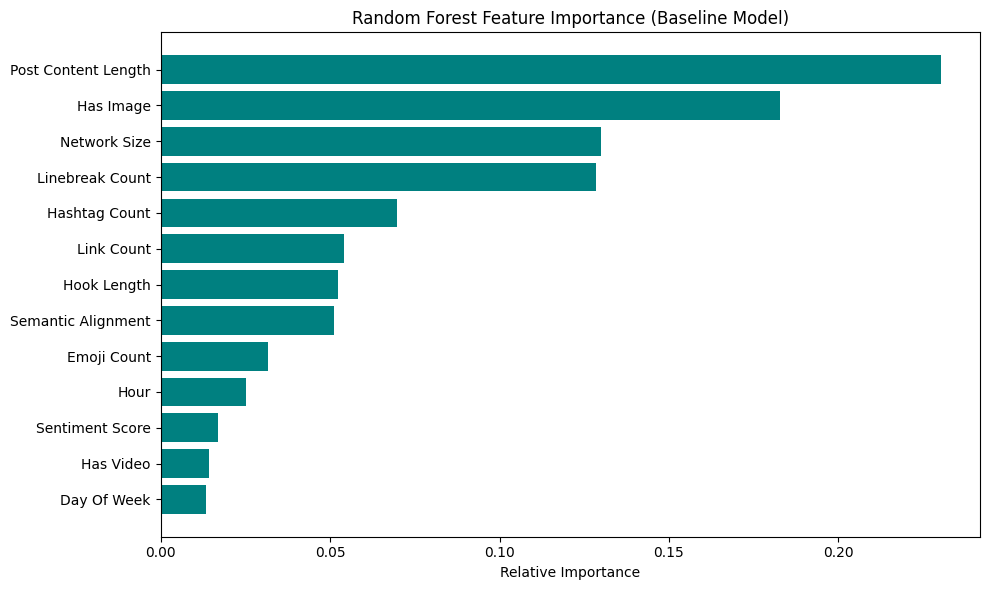

In [54]:
# VISUALIZATIONS
# 1. Feature Importance
importances = best_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance (Baseline Model)')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

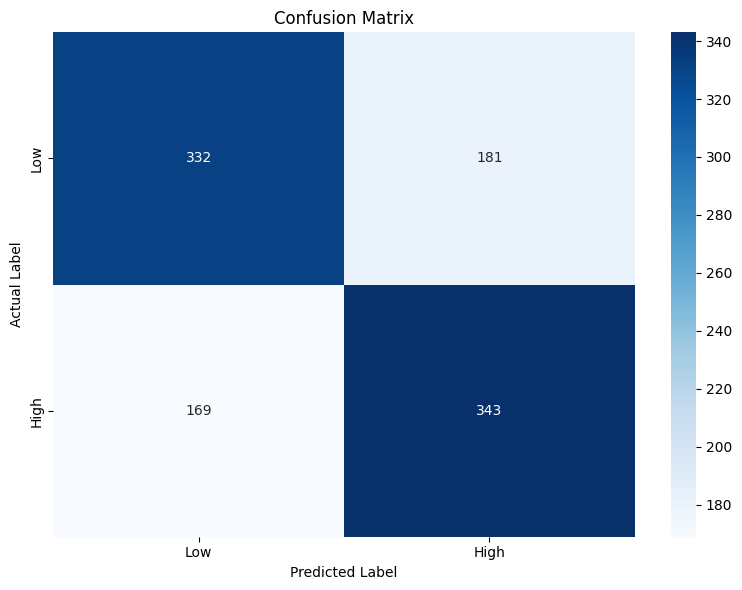

In [55]:
# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Plotting Learning Curve...


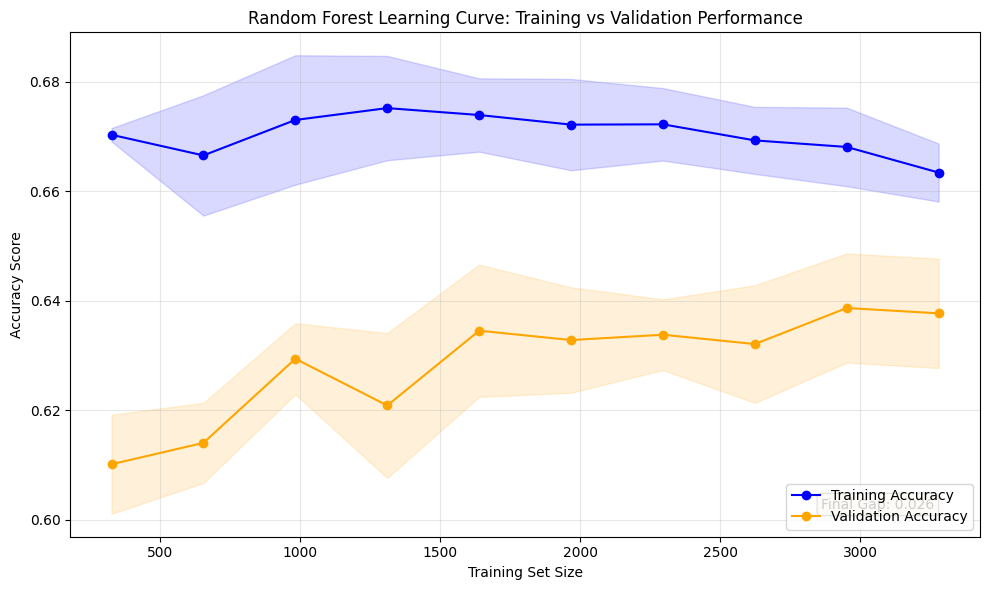

In [56]:
# 3. Learning Curve
from sklearn.model_selection import learning_curve
print('Plotting Learning Curve...')
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='orange', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='orange')
gap = train_mean[-1] - val_mean[-1]
plt.text(0.95, 0.05, f'Final Gap: {gap:.3f}', transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), verticalalignment='bottom', horizontalalignment='right')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Learning Curve: Training vs Validation Performance')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()